In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
from scipy.misc import factorial
import pymc3 as pm
from theano.compile.ops import as_op
import theano.tensor as T
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Simulate the data
np.random.seed(2)
x0low, x0high = 3400, 3700
x1low, x1high = 4400, 4700
dx = 15
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

In [3]:
# Convert to 1D arrays
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()

In [4]:
# Create model using simulated data
from sherpa.astro.models import Beta2D
truth = Beta2D()
truth.xpos, truth.ypos = 3551.3, 4552.4
truth.r0, truth.alpha = 8, 1.1
truth.ampl = 5

truth1 = Beta2D()
truth1.xpos, truth1.ypos = 3518.3, 4512.5
truth1.r0, truth1.alpha = 3, 2.1
truth1.ampl = 1600

In [5]:
# Evaluate the model to calculate the expected values:
mexp = truth(x0, x1).reshape(shape) #+ truth1(x0, x1).reshape(shape)

In [6]:
# Create the simulated data by adding in Poisson-distributed noise:
msim = np.random.poisson(mexp)
print(np.shape(msim))
print(msim.flatten())
print(np.random.poisson(msim.flatten()))

(20, 20)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

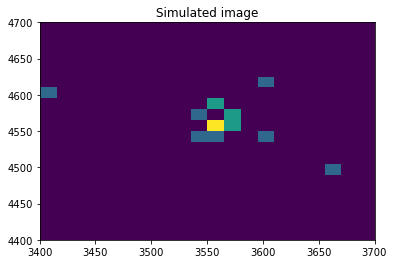

In [7]:
# Plot
plt.imshow(np.arcsinh(msim), origin='lower', cmap='viridis', 
           extent=(x0low, x0high, x1low, x1high), interpolation='nearest', aspect='auto')
plt.title('Simulated image')

In [8]:
# Set up a model and use the standard Sherpa approach to find a good starting place for the MCMC analysis:
from sherpa import data, stats, optmethods, fit
d = data.Data2D('sim', x0, x1, msim.flatten(), shape=shape)
mdl1 = Beta2D()
mdl2 = Beta2D()
mdl1.xpos, mdl1.ypos = 3550, 4550
mdl2.xpos, mdl2.ypos = 3550, 4550
mdl = mdl1 #+ mdl2

In [9]:
# Use a Likelihood statistic and Nelder-Mead algorithm:
f = fit.Fit(d, mdl, stats.Cash(), optmethods.NelderMead())
res = f.fit()
print(res.format())

Method                = neldermead
Statistic             = cash
Initial fit statistic = 81.3037
Final fit statistic   = 56.3406 at function evaluation 1094
Data points           = 400
Degrees of freedom    = 395
Change in statistic   = 24.9631
   beta2d.r0      1.96203     
   beta2d.xpos    3555.27     
   beta2d.ypos    4553.47     
   beta2d.ampl    122.76      
   beta2d.alpha   1.19197     


In [10]:
# Now calculate the covariance matrix (the default error estimate):
f.estmethod
eres = f.est_errors()
print(eres.format())

Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   beta2d.r0         1.96203        -----      4.86437
   beta2d.xpos       3555.27     -1.66269      1.66269
   beta2d.ypos       4553.47     -2.50476      2.50476
   beta2d.ampl        122.76     -672.682      672.682
   beta2d.alpha      1.19197    -0.163849     0.163849


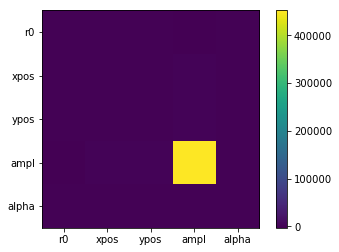

In [11]:
# The covariance matrix is stored in the extra_output attribute:
cmatrix = eres.extra_output
pnames = [p.split('.')[1] for p in eres.parnames]
plt.imshow(cmatrix, interpolation='nearest', cmap='viridis')
plt.xticks(np.arange(5), pnames)
plt.yticks(np.arange(5), pnames)
plt.colorbar()

In [12]:
# Finally, run a chain (use a small number to keep the run time low for this example):
from sherpa.sim import MCMC
mcmc = MCMC()
mcmc.get_sampler_name()
draws = mcmc.get_draws(f, cmatrix, niter=3000)
svals, accept, pvals = draws

print(pvals.shape)

accept.sum() * 1.0 / 1000

Using Priors:
beta2d.r0: <function flat at 0x7fe6c2742620>
beta2d.xpos: <function flat at 0x7fe6c2742620>
beta2d.ypos: <function flat at 0x7fe6c2742620>
beta2d.ampl: <function flat at 0x7fe6c2742620>
beta2d.alpha: <function flat at 0x7fe6c2742620>
(5, 3001)


0.10100000000000001

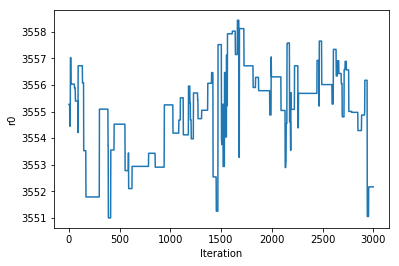

In [13]:
# Plot trace
plt.plot(pvals[1, :])
plt.xlabel('Iteration')
plt.ylabel('r0')

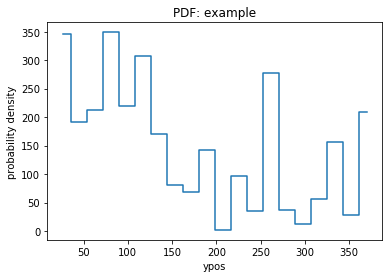

In [19]:
from sherpa import plot
# Parameter PDFs
parid = 3
pdf = plot.PDFPlot()
pdf.prepare(pvals[parid, :], 20, False, 'ypos', name='example')
pdf.plot()

# Add covariate estimate
#xlo, xhi = eres.parmins[parid] + eres.parvals[parid], eres.parmaxes[parid] + eres.parvals[parid]
#plt.annotate('', (xlo, 90), (xhi, 90), arrowprops={'arrowstyle': '<->'})
#plt.plot([eres.parvals[parid]], [90], 'ok')

In [21]:
source_model = pm.Model()

@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dmatrix])
def counts_func(r0, xpos, ypos, ampl, alpha):
    truth = Beta2D()
    truth.xpos, truth.ypos = xpos, ypos
    truth.r0, truth.alpha = r0, alpha
    truth.ampl = ampl
    #truth1 = Beta2D()
    #truth1.xpos, truth1.ypos = xpos1, ypos1
    #truth1.r0, truth1.alpha = r01, alpha1
    #truth1.ampl = ampl1
    return truth(x0, x1).reshape(shape) #+ truth1(x0, x1).reshape(shape)
 
with source_model:
    
    # priors
    BoundedNormal = pm.Bound(pm.Normal, lower=0.1, upper=100.0)
    r0 = BoundedNormal('r0', mu=10.0, sd=5.0)
    xpos = pm.Normal('xpos', mu=3550.0, sd=100.0)
    ypos = pm.Normal('ypos', mu=4550.0, sd=100.0)
    ampl = pm.Uniform('ampl', lower=0.0, upper=50.0)
    alpha = pm.Uniform('alpha', lower=0.0, upper=10.0)
    #r01 = BoundedNormal('r01', mu=2.0, sd=5.0)
    #xpos1 = pm.Normal('xpos1', mu=3550.0, sd=100.0)
    #ypos1 = pm.Normal('ypos1', mu=4550.0, sd=100.0)
    #ampl1 = pm.Uniform('ampl1', lower=0.0, upper=5000.0)
    #alpha1 = BoundedNormal('alpha1', mu=2.0, sd=5.0)
                       
    counts = counts_func(r0, xpos, ypos, ampl, alpha)
    #counts = np.empty_like(msim)
    
    #def log_like(img):
    #    logpm = counts - img*np.log(counts)
    #    return 2.0*logpm.sum()
    
    #likelihood = pm.DensityDist("likelihood", log_like, observed=msim)                   
    likelihood = pm.Poisson('likelihood', mu=counts, observed=msim)

In [12]:
map_estimate = pm.find_MAP(model=source_model)

logp = -577.99: 100%|██████████| 242/242 [00:00<00:00, 960.55it/s]  


In [13]:
map_estimate

{'alpha': array(10.0),
 'alpha_interval__': array(41.54183311011426),
 'ampl': array(652.5318880631163),
 'ampl_interval__': array(-1.896488902799377),
 'r0': array(37.91563691228448),
 'r0_interval__': array(-0.49313054466494627),
 'xpos': array(3550.5998888206127),
 'ypos': array(4551.425238728743)}

In [22]:
from scipy import optimize

with source_model:
    map_estimate = pm.find_MAP(fmin=scipy.optimize.fmin_powell, model=source_model)
    step = pm.Slice()
    trace = pm.sample(3000,step)

/export/jgalarza/software/anaconda/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -121.09:   4%|▎         | 179/5000 [00:00<00:07, 619.25it/s]


Optimization terminated successfully.
         Current function value: 121.048067
         Iterations: 3
         Function evaluations: 179


100%|██████████| 3500/3500 [01:12<00:00, 48.20it/s]


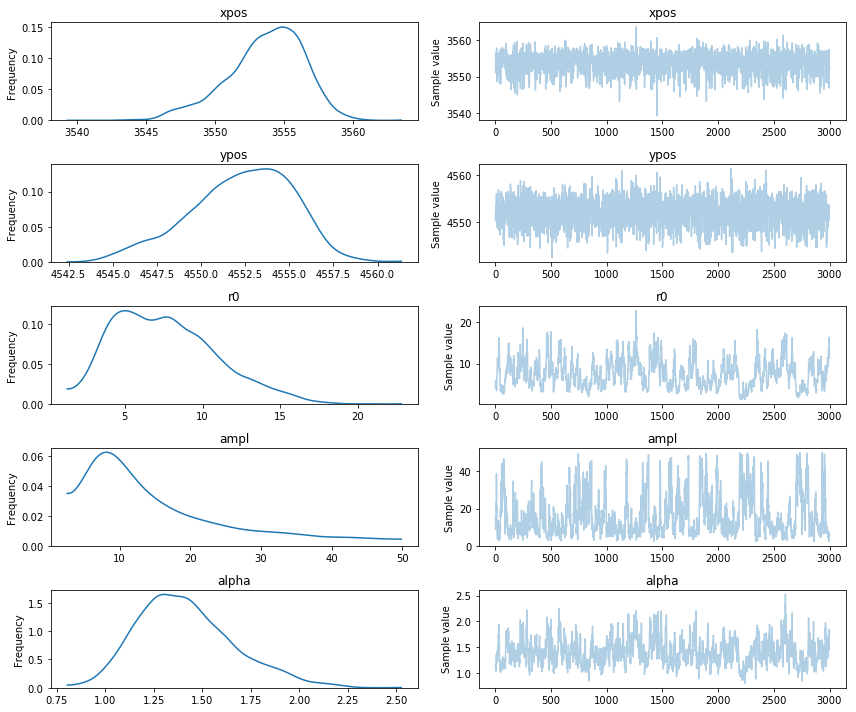

In [23]:
_ = pm.traceplot(trace)

In [26]:
pm.summary(trace)


xpos:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3551.159         1.795            0.126            [3547.348, 3554.121]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3547.214       3549.912       3551.520       3552.439       3554.051


ypos:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4552.603         1.709            0.151            [4549.191, 4555.610]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4547.389       4551.903       4553.002       4553.741       4554.865


ampl:

  Mean             SD               MC Error         95% HPD interval
  ----------

In [22]:
print(poisson(mu=2))